# VSB Powerline - augmented

basic L/R flip augmention for all (not just +ve)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [5]:
from fastai.vision import *

In [6]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [7]:
import fastai
print(fastai.__version__)

1.0.40.dev0


In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [9]:
DATE='20181231'

In [10]:
UID='9e22e11c'

In [11]:
MODEL_NAME='600_aug'

In [12]:
image_size=600
bs = 2  #16 too large

In [13]:
path = Path('../input/')
train_path = path/'train_600_aug/'

In [12]:
test_path = path/'test_600/'

In [13]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [14]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [15]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [16]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [17]:
aug_df['signal_id'] = aug_df['signal_id'].astype(str)+'_flip_lr'

#### remember to copy non aug images into folder

In [18]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [19]:
train_df.tail()

,signal_id,id_measurement,phase,target
17419,8707_flip_lr,2902,1,0
17420,8708_flip_lr,2902,2,0
17421,8709_flip_lr,2903,0,0
17422,8710_flip_lr,2903,1,0
17423,8711_flip_lr,2903,2,0


In [20]:
#lets drop augmented good images - CUDA oom errors

In [21]:
drop_df = train_df[(train_df['target'] == 0) & train_df['signal_id'].str.endswith('_flip_lr')]

In [22]:
idx_to_drop=list(drop_df.index.values)

In [23]:
len(idx_to_drop)

8187

In [24]:
train_df=train_df.drop(train_df.index[idx_to_drop])

In [25]:
train_df.tail()

,signal_id,id_measurement,phase,target
17195,8483_flip_lr,2827,2,1
17280,8568_flip_lr,2856,0,1
17281,8569_flip_lr,2856,1,1
17282,8570_flip_lr,2856,2,1
17342,8630_flip_lr,2876,2,1


### Image Data

In [26]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [27]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

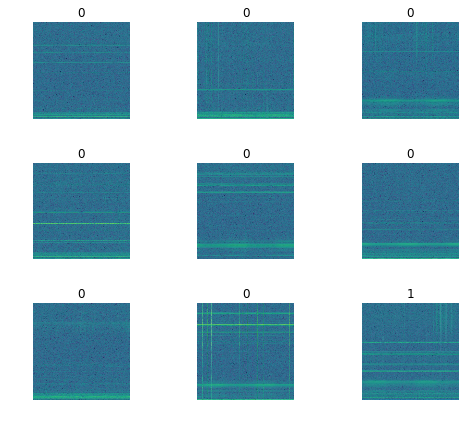

In [28]:
data.show_batch(rows=3, figsize=(7,6))

In [29]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [28]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### use 2x GPU's

This fails using 1x GPU and a bs of 2 - try with larger bs

In [29]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


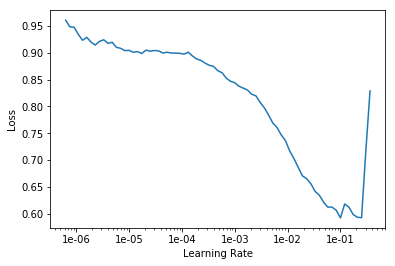

In [32]:
learn.recorder.plot()

#### fit

In [34]:
learn.fit_one_cycle(5, 9e-3)

epoch,train_loss,valid_loss,error_rate
1,0.244995,0.121245,0.041689
2,0.152805,0.085808,0.029778
3,0.127311,0.077139,0.034651
4,0.103663,0.067818,0.027612
5,0.084239,0.056551,0.022740


In [35]:
learn.save(f'{MODEL_NAME}_stage-1')

## Results

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

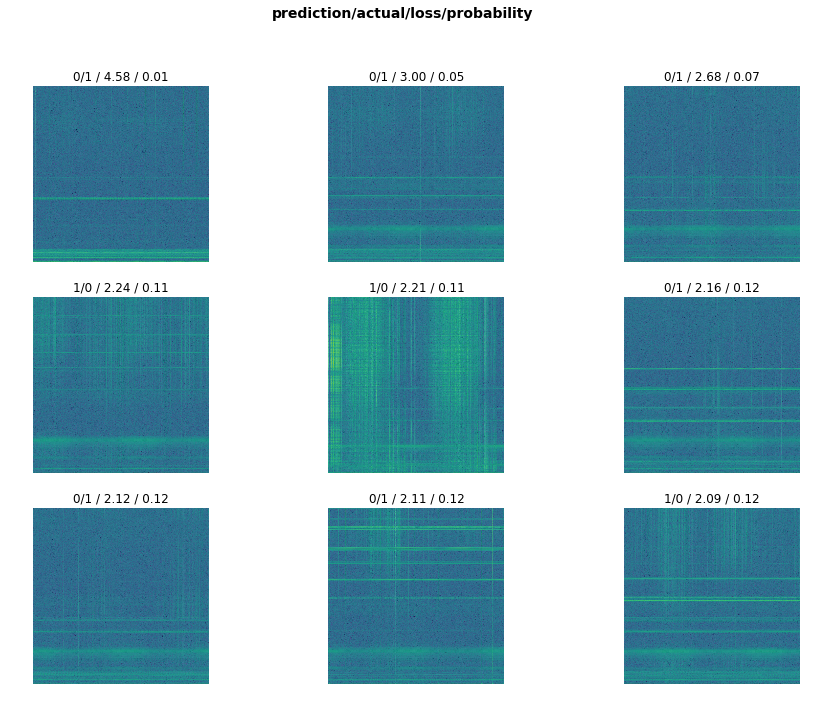

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

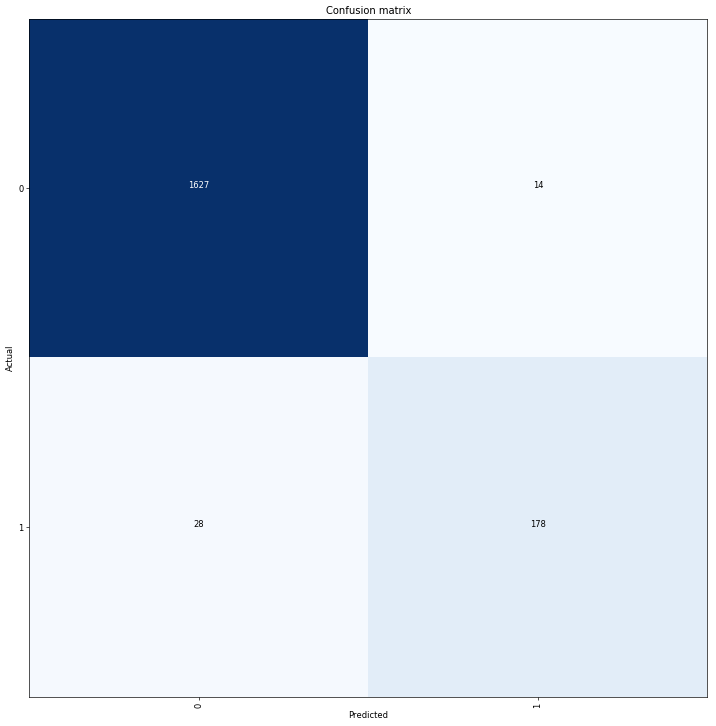

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[(1, 0, 28), (0, 1, 14)]

### Predict

In [95]:
learn.load(f'{MODEL_NAME}_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7390 items)
[Category 0, Category 0, Category 1, Category 1, Category 0]...
Path: ../input/train_600_aug
x: ImageItemList (7390 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_aug;

Valid: LabelList
y: CategoryList (1847 items)
[Category 1, Category 0, Category 0, Category 1, Category 0]...
Path: ../input/train_600_aug
x: ImageItemList (1847 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 300, 300), Image (3, 600, 600)]...
Path: ../input/train_600_aug;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(


In [76]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [77]:
len(test_images), test_path

(20337, PosixPath('../input/test_600'))

In [78]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    if i==0:
        print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

signal_id: 8847, cat: 0, val: 0


In [79]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [80]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [81]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [83]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_aug_stage-1_{DATE}_{UID}.csv', index=False)
#submission 5 0.550
#submission_600_aug_stage-1_20181231_9e22e11c.csv

## Unfreezing, fine-tuning, and learning rates

sequence used when restarting NB here

restart NB

learn = create_cnn()

lean.model = dataparallel

learn.load

learn.unfreeze

learn.find

In [38]:
learn.load(f'{MODEL_NAME}_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7390 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: ../input/train_600_aug
x: ImageItemList (7390 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_aug;

Valid: LabelList
y: CategoryList (1847 items)
[Category 1, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_600_aug
x: ImageItemList (1847 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_aug;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ce

In [39]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


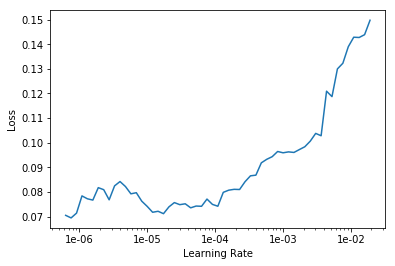

In [33]:
learn.recorder.plot()

In [40]:
#learn.fit_one_cycle(5, max_lr=slice(1e-6,2e-5))
#5, max_lr=5e-6 final val_loss:0.057145
#5, max_lr=4e-6 final val_loss:0.059421, best after 1 epoch 0.055140
learn.fit_one_cycle(1, max_lr=4e-6)

epoch,train_loss,valid_loss,error_rate
1,0.072860,0.055397,0.021657


In [41]:
learn.save(f'{MODEL_NAME}_stage-2_unfeeze')

### 1x1 prediction

In [39]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [42]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [43]:
len(test_images)

20337

In [44]:
assert 20337 == len(test_images)

In [45]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [46]:
cat, val, probs=learn.predict(img)

In [47]:
cat.__str__()

'0'

In [48]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [49]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [50]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [51]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [52]:
df_sub.head()

,signal_id,target
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [53]:
df_sub.target.nunique()

2

In [54]:
len(df_sub)

20337

In [55]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)
#submission 6 - TODO
#

In [56]:
print('saved')

saved


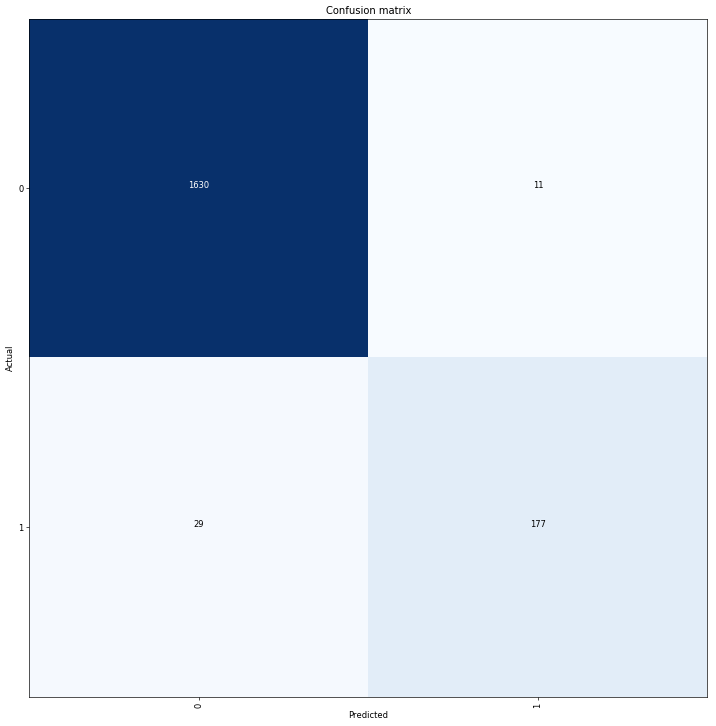

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [1]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=4)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

NameError: name 'ImageDataBunch' is not defined

In [2]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

NameError: name 'create_cnn' is not defined

In [41]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [42]:
learn.lr_find()


RuntimeError: CUDA out of memory. Tried to allocate 2.25 MiB (GPU 0; 10.91 GiB total capacity; 10.22 GiB already allocated; 2.69 MiB free; 8.51 MiB cached)

In [ ]:
learn.recorder.plot()

In [56]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.164189,0.160105,0.051378
2,0.136634,0.128991,0.047359
3,0.118678,0.130966,0.045637
4,0.158146,0.117710,0.045350
5,0.121506,0.114018,0.043628
6,0.072220,0.130025,0.048794
7,0.132934,0.112650,0.044489
8,0.132413,0.118317,0.043915


In [57]:
#learn.fit_one_cycle(8)

In [58]:
learn.save('aug_stage-1-50')

In [59]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.209580,0.139430,0.054535
2,0.162383,0.122988,0.055683
3,0.106317,0.099513,0.040184


In [60]:
learn.save('aug_stage-2-50')

In [61]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.114230,0.130576,0.050804
2,0.119835,2.006721,0.049656
3,0.085578,0.974430,0.041906


In [62]:
learn.save('aug_stage-2-2-50')

In [63]:
#learn.load('baseline_stage-1-50');

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

In [65]:
interp.most_confused(min_val=2)

[(1, 0, 126), (0, 1, 20)]

In [66]:
### Predict

In [72]:
learn.load('aug_stage-2-50')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (13940 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: ../input/train_300_aug
x: ImageItemList (13940 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_aug;

Valid: LabelList
y: CategoryList (3484 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_300_aug
x: ImageItemList (3484 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_aug;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential

In [73]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [74]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [75]:
df_sub_50_u=df_sub_50_u.reset_index()


In [76]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [77]:
df_sub_50_u.to_csv(path/f'submissions/submission_aug_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 3 0.478
#submission_aug_resnet-50_unfeeze-2-2_20181229_d1a603dc.csv
